## Dataset

In [1]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))
])

mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train, valid, test = random_split(mnist, lengths=[.75, .1, .15])

train_loader = DataLoader(train, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

len(train), len(valid), len(test)

(45000, 6000, 9000)

## Model

In [3]:
# pytorch
import torch
from torch import tensor
import torch.nn as nn

# lightning
import pytorch_lightning as L

# other
import os
import pandas as pd
import matplotlib.pyplot as plt

2024-06-16 17:45:40.054418: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 17:45:40.103876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, embedding_dim: int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.layer(x)
        return x


class Decoder(nn.Module):
    def __init__(self, embedding_dim: int, output_dim: int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(embedding_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.layer(x)
        return x


class Autoencoder(L.LightningModule):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()

        self.loss_fn = nn.MSELoss()

        self.encoder = Encoder(input_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        y = x # because autoencoder

        output = self.forward(x)
        loss = self.loss_fn(output, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(lr=0.001, params=self.parameters())


In [7]:
log_save_dir = 'autoencoder_logs'

input_dim = 784
embedding_dim = 50

model = Autoencoder(input_dim, embedding_dim)

trainer = L.Trainer(
    logger=L.loggers.CSVLogger(save_dir=log_save_dir),
    max_epochs=10
)

trainer.fit(
    model, 
    train_loader, 
    valid_loader,
)

logs_df = get_latest_logs_as_df(log_save_dir)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | loss_fn | MSELoss | 0     
1 | encoder | Encoder | 39.2 K
2 | decoder | Decoder | 40.0 K
------------------------------------
79.2 K    Trainable params
0         Non-trainable params
79.2 K    Total params
0.317     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


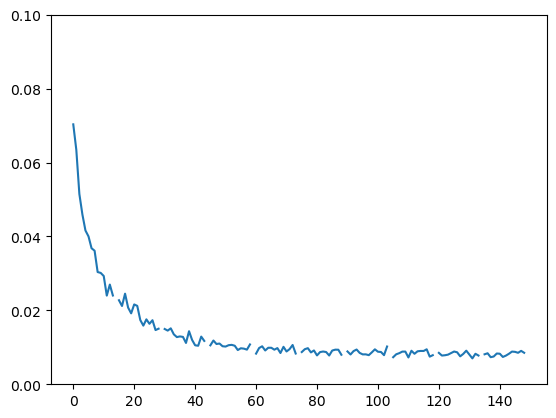

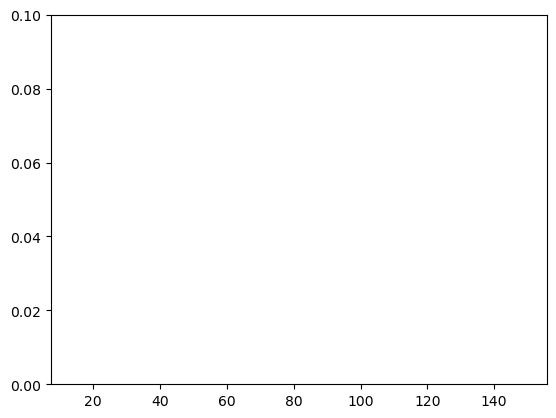

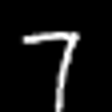

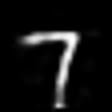

In [10]:
# logs_df

y_lim = .1

logs_df.train_loss.plot()
plt.ylim(0, y_lim)
plt.show()
logs_df.val_loss.plot()
plt.ylim(0, y_lim)
plt.show()


# visual test

test_ex = test[0][0]
display_tensor_as_image(test_ex)
display_tensor_as_image(model(test_ex))

## Visualization utils

In [6]:
from pathlib import Path

def get_latest_logs_as_df(log_save_dir) -> pd.DataFrame:
    log_versions_dir = f'{log_save_dir}/lightning_logs'
    latest_log_dir = os.listdir(log_versions_dir)[-1]
    latest_csv = f'{log_versions_dir}/{latest_log_dir}/metrics.csv'

    return pd.read_csv(latest_csv)


def display_tensor_as_image(tensor):
    to_img = transforms.ToPILImage()
    tensor = tensor.view(28, 28)
    img: Image.Image = to_img(tensor)
    img = img.resize((28*4, 28*4))
    display(img)


In [24]:
logs_df = get_latest_logs_as_df('autoencoder_logs')